In [1]:
import matplotlib.pyplot as plt
%pylab inline
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn import preprocessing
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


<h1>Get the Data:</h1>
(Only from Engine 1. The Ship has 2 Engines in total)

In [2]:
# Load Seadevcon data from Engin 1 ship W50DF_00092:
ship1_seadevcon = pd.read_pickle("ship1_seadevcon") # do not use this. We need the unmanipulated data
PATH = "/Users/basti/Documents/MLDatasets/SeaDevConChallange/"
SHIP1 = PATH + "W50DF_00092/"
ship1_seadevcon_init = pd.read_csv(SHIP1 + "W50DF_00092_01_seadevcon.csv")

In [3]:
# Load Runlog data from Engin 1 ship W50DF_00092:
ship1_runlog = pd.read_csv(SHIP1 + "W50DF_00092_01_runlog.csv") 

In [4]:
# Load Tags for Seadevcon:
tags = pd.read_csv(PATH + "SensorTags_SeaDevCon.csv", sep='\t', header=None)
SHIP1_engine1 = "W50DF_00092" + "_01"

<h1>Basic cleaning of Seadevcon</h1>
(Without deleting any rows!)

In [5]:
# Remove about 2/3 of the features (min and max values:)
print("Before:",ship1_seadevcon_init.shape)
remove_tags = []
for colTag in ship1_seadevcon_init:
    if "_max" in colTag or "_min" in colTag:
        remove_tags.append(colTag)

ship1_seadevcon = ship1_seadevcon_init.drop(remove_tags, axis=1)
print("After: ",ship1_seadevcon.shape)
print("Removed",len(remove_tags),"features")

Before: (699768, 249)
After:  (699768, 87)
Removed 162 features


<h3>Replace column name tags with real names </h3>

In [6]:
columns = list(ship1_seadevcon.columns.values)
for i, colTag in enumerate(columns):
    if colTag in tags[2].values:
        # find row in tags dataFrame which contains the current tag that we are searching the name for.
        a = tags.loc[tags[2] == colTag] # a = the rows
        b = a.loc[a[1] == SHIP1_engine1]
        columns[i] = b[3].values[0]
        # print(b[3].values[0])
ship1_seadevcon1 = pd.DataFrame(ship1_seadevcon.values, None, columns) # copies whole dataset into new pd frame. Takes a lot of time.

In [7]:
ship1_seadevcon = ship1_seadevcon1

In [8]:
FuelTypeAnalog = ship1_seadevcon["FuelTypeAnalog"]
FuelTypeAnalog.tail()

699763    Gas
699764    Gas
699765    Gas
699766    Gas
699767    Gas
Name: FuelTypeAnalog, dtype: object

In [9]:
ship1_seadevcon1 = ship1_seadevcon.copy
type(ship1_seadevcon1)

method

In [10]:
def exchange_cols(df, name_col_1, name_col_2):
    col_1 = df[name_col_1]
    col_2 = df[name_col_2]

    df_copy = df.copy()
    df_copy[name_col_1] = col_2
    df_copy[name_col_2] = col_1

    df_copy = df_copy.rename(columns={name_col_1: name_col_2, name_col_2: name_col_1}) # change titles
    return df_copy

In [11]:
# Switch last two features of Seadevcon (so the Objectiv is in the last col):
ship1_seadevcon = exchange_cols(ship1_seadevcon, "Load", "FuelTypeAnalog")
ship1_seadevcon.tail()

,ts,"Enclosure underpressure GVU, PDS01",Inlet gas pressure,Gas pressure between shut-off valves,Inert gas pressure,"Instrument air pressure GVU, PT006",Inlet gas temperature,Fuel rack control,Exh WG valve control value,By Pass valve control,...,"Engine exh. gas average temp, TY500","Engine load feedback, torque","Torsional vibration level, mean",Calculated engine load,RunNumber,MinutesSinceStart,mode,CumRunningHours,Load,FuelTypeAnalog
699763,NaN,NaN,NaN,NaN,NaN,6.91,NaN,0,NaN,NaN,...,NaN,76.0046,72.625,3933,1421,318,running,13554.5,68.4444,Gas
699764,NaN,NaN,NaN,NaN,NaN,6.9075,NaN,0,8.6,NaN,...,NaN,75.3092,75.5,3876.52,1421,320,running,13554.5,68.4115,Gas
699765,NaN,NaN,3.64,3.62,NaN,6.922,NaN,0,NaN,NaN,...,NaN,73.9783,89.9231,3851.3,1421,322,running,13554.5,67.1778,Gas
699766,NaN,-57,3.67,3.64,0.57,6.985,35.5,0,8.63333,0,...,494.4,76.4771,72.7826,3964.92,1421,324,running,13554.6,69.0697,Gas
699767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,NaN,...,NaN,75.4373,73.5909,3890.82,NaN,NaN,NaN,NaN,68.2304,Gas


In [12]:
#remove >80% Nan columns:
PERCENT_NAN_REMOVE = 0.8 # remove features that have more than 80% NaN values
percent_nan = []
remove_tags = []
for col in ship1_seadevcon:
    ship_df = ship1_seadevcon[col]
    nans = np.sum(ship_df.isnull().values)
    percent_nan.append(nans/ship_df.shape[0])
    if percent_nan[-1] > PERCENT_NAN_REMOVE:
        remove_tags.append(col)
print("Removed: ", remove_tags, "because more than",PERCENT_NAN_REMOVE*100,"% are NaN")
ship1_seadevcon = ship1_seadevcon.drop(remove_tags, axis=1)

Removed:  ['ts', 'SCA011GTY1623PV_C'] because more than 80.0 % are NaN


<h1>Runlog:</h1>

In [13]:
ship1_runlog.tail()

,start,end,duration,mode,RunningHours,RunNumber,CumRunningHours
2946,2015-09-02T22:52:19.515Z,2015-09-03T18:24:36.546Z,70337.031,not running,0.00,1420.0,13527.26
2947,2015-09-03T18:24:36.546Z,2015-09-04T16:20:02.562Z,78926.016,running,21.92,1420.0,13549.18
2948,2015-09-04T16:20:02.562Z,2015-09-04T21:32:26.515Z,18743.953,not running,0.00,1421.0,13549.18
2949,2015-09-04T21:32:26.515Z,2015-09-05T02:46:43.078Z,18856.563,running,5.24,1421.0,13554.42
2950,2015-09-05T02:46:43.078Z,2015-09-05T02:56:43Z,599.922,not running,0.00,NaN,13554.42


In [14]:
# Replace start and end time with Pandas datetime datatype: 
ship1_runlog['start'] = pd.to_datetime(ship1_runlog["start"])
ship1_runlog['start'] = ship1_runlog['start'].apply(lambda t: t.replace(microsecond=0)) # remove milliseconds

ship1_runlog['end'] = pd.to_datetime(ship1_runlog["end"])
ship1_runlog['end'] = ship1_runlog['end'].apply(lambda t: t.replace(microsecond=0))     # remove milliseconds

print(ship1_runlog['start'].head())
print(ship1_runlog['end'].head())

0   2011-10-18 03:00:00
1   2011-10-18 15:11:50
2   2011-10-18 15:17:15
3   2011-10-19 02:53:40
4   2011-10-21 03:00:00
Name: start, dtype: datetime64[ns]
0   2011-10-18 15:11:50
1   2011-10-18 15:17:15
2   2011-10-19 02:43:40
3   2011-10-21 03:00:00
4   2011-10-21 10:37:44
Name: end, dtype: datetime64[ns]


It looks like for each RunNumber there are always two states, "running" and "not running". We are only interested in the timeframes where the ship is running, so I will remove all other rows. But first check if it's true that there are only the two states:

In [15]:
# Check if there is only "running" and "not running" as entries in the Runlog.
allShapes = []
max_val = 0
i_max = 0
for i in range(int(ship1_runlog['RunNumber'].max())):      # for all RunNumbers
    x = ship1_runlog.loc[ship1_runlog['RunNumber'] == i]
    entries = x.shape[0]
    allShapes.append(entries)                              # save shape of entries
    if (entries > max_val):
        max_val = entries                                   
        i_max = i                                          # and RunNumber with most entries
print("Max entries per run over all runs:", max(allShapes)) # (== max_val)
print("There are sometimes more than two entries in the runlog. Why is that?\n")

print(ship1_runlog.loc[ship1_runlog['RunNumber'] == i_max])
print("\nSo there sometimes is \"no data\" about the run mode, but it's only between not running modes.")
print("So I will assume the vessle is also not running when mode is \"no data\".")

Max entries per run over all runs: 8
There are sometimes more than two entries in the runlog. Why is that?

                   start                 end   duration         mode  \
1111 2013-04-15 03:48:37 2013-04-15 11:06:45  26288.344  not running   
1112 2013-04-15 11:16:45 2013-04-15 12:31:24   4478.828      no data   
1113 2013-04-15 12:31:24 2013-04-15 13:51:24   4799.813  not running   
1114 2013-04-15 13:59:05 2013-04-15 15:52:17   6791.797      no data   
1115 2013-04-15 15:52:17 2013-04-15 16:22:16   1798.406  not running   
1116 2013-04-15 16:32:16 2013-04-15 17:44:39   4342.953      no data   
1117 2013-04-15 17:44:39 2013-04-15 22:37:48  17589.640  not running   
1118 2013-04-15 22:37:48 2013-04-15 22:40:20    152.000      running   

      RunningHours  RunNumber  CumRunningHours  
1111          0.00      526.0          4351.69  
1112          0.00      526.0          4351.69  
1113          0.00      526.0          4351.69  
1114          0.00      526.0          4351.69 

In [16]:
# We are only interested in the "running" datapoints:
ship1_runlog = ship1_runlog[ship1_runlog['mode'] == "running"]

# Test:
allShapes = []
for i in range(int(ship1_runlog['RunNumber'].max())):
    x = ship1_runlog.loc[ship1_runlog['RunNumber'] == i]
    allShapes.append(x.shape[0])
print("Max entries per run over all runs:", max(allShapes))
if max(allShapes) == 1:
    print("Ok! we can continue...")
else:
    print("Something went wrong")

ship1_runlog.head()

Max entries per run over all runs: 1
Ok! we can continue...


,start,end,duration,mode,RunningHours,RunNumber,CumRunningHours
1,2011-10-18 15:11:50,2011-10-18 15:17:15,324.985,running,0.09,1.0,0.09
5,2011-10-21 10:37:44,2011-10-21 11:59:42,4918.000,running,1.37,2.0,1.46
9,2011-10-21 17:14:04,2011-10-21 17:19:44,340.032,running,0.09,3.0,1.55
11,2011-10-21 17:21:43,2011-10-21 17:58:01,2177.610,running,0.60,4.0,2.15
13,2011-10-21 17:59:39,2011-10-21 18:01:12,93.407,running,0.03,5.0,2.18


Now we want to write the timestamps onto the ship1_seadevcon data. Before we can do that, we have to check if the data is compatible. In this case we have to check how long the time between two rows in seadevcon is and if it's constant over all runs. If so, we can interpolate between start and end point of a run to fill in the missing time stamps in the ship1_seadevcon table.

In [17]:
# Is the time between two rows in seadevcon constant? If yes how long is it? (2min?) 
# -> Havent figured it out. See description below (Directly above the "Month and year of run to seadevcon data" header)

# We first need the amount of entries for every RunNumber in the Seadevcon file:

rows_for_each_run_number = np.zeros(int(ship1_seadevcon["RunNumber"].max())).astype(np.int32)

for run in range(rows_for_each_run_number.shape[0]):
    rows_for_each_run_number[run] = np.where(ship1_seadevcon["RunNumber"].values == run)[0].shape[0]
    #print(run)

print("Amount of entries, e.g. for run 0 to 60:")
print(rows_for_each_run_number[0:60])

Amount of entries, e.g. for run 0 to 60:
[   0  358  595  107   19    0    1    2    1    1    5    1    9    5
    1   10    8    0   47   10    1    0    0    0   14    1    0    1
   67  129    0    6    1    7    7    4  147    3    3    1   32   23
  203    3    2    5  178  366    4   20 1027   47  635    2  871  711
  174  646  314  426]


In [18]:
# In our second step we check if in Runlog the "duration" column represents the difference between the "start" and "end" column.
unequal_count = 0
differences = []

for run in range(int(ship1_runlog['RunNumber'].max())):
    current_row = ship1_runlog[ship1_runlog['RunNumber'] == run]
    time_diff_in_sec = (current_row['end']-current_row['start']).dt.total_seconds() # difference between start and end in seconds
    duration_column_value = np.round(current_row['duration'].values, 0) # get duration and round the milliseconds away
    #print(time_diff_in_sec.values)
    #print(duration_column_value,"\n")
    
    if time_diff_in_sec.size > 0: # not []
        # to int and scalar:
        time_diff_in_sec = np.asscalar(time_diff_in_sec.astype(np.int))
        duration_column_value = np.asscalar(duration_column_value.astype(np.int))
    
        # Sometimes the duration column has one second less. That's ok.
        if time_diff_in_sec != duration_column_value :
            # print("Difference from (start-end) and duration:",duration_column_value - time_diff_in_sec,"seconds")
            differences.append(duration_column_value - time_diff_in_sec)
            unequal_count+=1
    
print("The max difference between duration column values and end-start is", max(map(abs, differences)),"second")
print("So indeed we can say, that duration describes the time from \"start\" to \"end\" in seconds (± 1 sec)")

The max difference between duration column values and end-start is 1 second
So indeed we can say, that duration describes the time from "start" to "end" in seconds (± 1 sec)


<h3>Amount of rows in each run in Seadevcon divided by the duration of that run from Runlog</h3>

(should be constant for each Run number)

In [19]:
for run in range(int(ship1_runlog['RunNumber'].max())):
    print("RUN",run)
    # if rows_for_each_run_number[run] != 0:
    print("rows in seadevcon       ", rows_for_each_run_number[run])
    print("duration from runlog [s]", ship1_runlog['duration'].iloc[run])
    print("ratio                   ", rows_for_each_run_number[run]/ship1_runlog['duration'].iloc[run])
    print() # newline
    

RUN 0
rows in seadevcon        0
duration from runlog [s] 324.984999895096
ratio                    0.0

RUN 1
rows in seadevcon        358
duration from runlog [s] 4918.0
ratio                    0.0727938186254575

RUN 2
rows in seadevcon        595
duration from runlog [s] 340.03200006485
ratio                    1.7498353092841943

RUN 3
rows in seadevcon        107
duration from runlog [s] 2177.6099998951
ratio                    0.049136438574930504

RUN 4
rows in seadevcon        19
duration from runlog [s] 93.4070000648498
ratio                    0.2034108791290679

RUN 5
rows in seadevcon        0
duration from runlog [s] 93.45299983024599
ratio                    0.0

RUN 6
rows in seadevcon        1
duration from runlog [s] 168.530999898911
ratio                    0.005933626458039318

RUN 7
rows in seadevcon        2
duration from runlog [s] 78.5159997940064
ratio                    0.02547251522297589

RUN 8
rows in seadevcon        1
duration from runlog [s] 93.56200003

RUN 170
rows in seadevcon        0
duration from runlog [s] 14.0
ratio                    0.0

RUN 171
rows in seadevcon        0
duration from runlog [s] 6.0
ratio                    0.0

RUN 172
rows in seadevcon        0
duration from runlog [s] 2.0
ratio                    0.0

RUN 173
rows in seadevcon        1
duration from runlog [s] 2.0
ratio                    0.5

RUN 174
rows in seadevcon        2
duration from runlog [s] 320.0
ratio                    0.00625

RUN 175
rows in seadevcon        68
duration from runlog [s] 267.0
ratio                    0.2546816479400749

RUN 176
rows in seadevcon        3
duration from runlog [s] 1206.0160000324302
ratio                    0.002487529186942237

RUN 177
rows in seadevcon        14
duration from runlog [s] 561.0
ratio                    0.024955436720142603

RUN 178
rows in seadevcon        122
duration from runlog [s] 151.0
ratio                    0.8079470198675497

RUN 179
rows in seadevcon        169
duration from runlog 

duration from runlog [s] 66019.7189998627
ratio                    1.514698964414071e-05

RUN 352
rows in seadevcon        551
duration from runlog [s] 5178.32800006867
ratio                    0.1064050017674997

RUN 353
rows in seadevcon        121
duration from runlog [s] 116969.0
ratio                    0.0010344621224426984

RUN 354
rows in seadevcon        1232
duration from runlog [s] 36188.0160000324
ratio                    0.03404441956693334

RUN 355
rows in seadevcon        410
duration from runlog [s] 14019.5940001011
ratio                    0.029244784121212307

RUN 356
rows in seadevcon        390
duration from runlog [s] 26433.3120000362
ratio                    0.014754110268114184

RUN 357
rows in seadevcon        220
duration from runlog [s] 5241.04699993134
ratio                    0.04197634556661715

RUN 358
rows in seadevcon        470
duration from runlog [s] 76612.0
ratio                    0.0061348091682765105

RUN 359
rows in seadevcon        669
duration 

ratio                    1.4407894736842106

RUN 526
rows in seadevcon        416
duration from runlog [s] 153.0
ratio                    2.718954248366013

RUN 527
rows in seadevcon        4
duration from runlog [s] 409.0
ratio                    0.009779951100244499

RUN 528
rows in seadevcon        4
duration from runlog [s] 440.608999967575
ratio                    0.009078343838401769

RUN 529
rows in seadevcon        4
duration from runlog [s] 32127.983999967597
ratio                    0.00012450205403501303

RUN 530
rows in seadevcon        1535
duration from runlog [s] 22122.0149998665
ratio                    0.06938789255903059

RUN 531
rows in seadevcon        523
duration from runlog [s] 35565.0469999313
ratio                    0.014705449426258604

RUN 532
rows in seadevcon        454
duration from runlog [s] 60023.0160000324
ratio                    0.007563765206329434

RUN 533
rows in seadevcon        899
duration from runlog [s] 83209.03200006491
ratio               

ratio                    0.00148574734406227

RUN 704
rows in seadevcon        634
duration from runlog [s] 103.82799983024599
ratio                    6.106252658594608

RUN 705
rows in seadevcon        351
duration from runlog [s] 109701.0
ratio                    0.0031996062023135615

RUN 706
rows in seadevcon        915
duration from runlog [s] 4873.04699993134
ratio                    0.18776753025630413

RUN 707
rows in seadevcon        320
duration from runlog [s] 156753.96899986302
ratio                    0.0020414156148115116

RUN 708
rows in seadevcon        1535
duration from runlog [s] 103.0
ratio                    14.902912621359222

RUN 709
rows in seadevcon        441
duration from runlog [s] 102.0
ratio                    4.323529411764706

RUN 710
rows in seadevcon        0
duration from runlog [s] 4152.96899986267
ratio                    0.0

RUN 711
rows in seadevcon        56
duration from runlog [s] 23942.7179999352
ratio                    0.002338915740483246

ratio                    2.2

RUN 881
rows in seadevcon        0
duration from runlog [s] 103282.01499986599
ratio                    0.0

RUN 882
rows in seadevcon        861
duration from runlog [s] 130686.98399996801
ratio                    0.006588261306881263

RUN 883
rows in seadevcon        1663
duration from runlog [s] 72156.32800006871
ratio                    0.02304718166920047

RUN 884
rows in seadevcon        1232
duration from runlog [s] 116.0
ratio                    10.620689655172415

RUN 885
rows in seadevcon        685
duration from runlog [s] 18822.0160000324
ratio                    0.03639355104144109

RUN 886
rows in seadevcon        157
duration from runlog [s] 122.0
ratio                    1.2868852459016393

RUN 887
rows in seadevcon        308
duration from runlog [s] 64025.0469999313
ratio                    0.004810617319817516

RUN 888
rows in seadevcon        533
duration from runlog [s] 99.0
ratio                    5.383838383838384

RUN 889
rows in s

ratio                    0.010179788356895291

RUN 1058
rows in seadevcon        1018
duration from runlog [s] 38573.984999895096
ratio                    0.026390843466205748

RUN 1059
rows in seadevcon        390
duration from runlog [s] 27572.015999794
ratio                    0.01414477635595866

RUN 1060
rows in seadevcon        343
duration from runlog [s] 6725.04699993134
ratio                    0.05100336101792328

RUN 1061
rows in seadevcon        96
duration from runlog [s] 29932.016000032403
ratio                    0.003207268097140402

RUN 1062
rows in seadevcon        343
duration from runlog [s] 20568.9839999676
ratio                    0.016675592727406482

RUN 1063
rows in seadevcon        261
duration from runlog [s] 177622.03100013698
ratio                    0.0014694123163122637

RUN 1064
rows in seadevcon        1517
duration from runlog [s] 33053.984000206
ratio                    0.0458946189358156

RUN 1065
rows in seadevcon        364
duration from runlog [s]

RUN 1235
rows in seadevcon        674
duration from runlog [s] 4118.96899986267
ratio                    0.16363318102721136

RUN 1236
rows in seadevcon        215
duration from runlog [s] 1.0
ratio                    215.0

RUN 1237
rows in seadevcon        1180
duration from runlog [s] 177328.0
ratio                    0.006654335468735902

RUN 1238
rows in seadevcon        1478
duration from runlog [s] 28671.9690001011
ratio                    0.05154860484101348

RUN 1239
rows in seadevcon        491
duration from runlog [s] 68888.22699999809
ratio                    0.007127487836201875

RUN 1240
rows in seadevcon        821
duration from runlog [s] 3629.25699996948
ratio                    0.2262171017392552

RUN 1241
rows in seadevcon        31
duration from runlog [s] 4945.23399996758
ratio                    0.006268661907647491

RUN 1242
rows in seadevcon        61
duration from runlog [s] 123816.02200007401
ratio                    0.0004926664499039029

RUN 1243
rows in sea

RUN 1414
rows in seadevcon        1241
duration from runlog [s] 75467.0
ratio                    0.01644427365603509

RUN 1415
rows in seadevcon        1394
duration from runlog [s] 1.0
ratio                    1394.0

RUN 1416
rows in seadevcon        255
duration from runlog [s] 50257.0
ratio                    0.005073920050938178

RUN 1417
rows in seadevcon        419
duration from runlog [s] 39634.0469999313
ratio                    0.010571718805317213

RUN 1418
rows in seadevcon        752
duration from runlog [s] 1055.0
ratio                    0.7127962085308057

RUN 1419
rows in seadevcon        306
duration from runlog [s] 78926.0160000324
ratio                    0.00387704860207152

RUN 1420
rows in seadevcon        1244
duration from runlog [s] 18856.5629999638
ratio                    0.06597172560038582



So it seems like the duration between rows in seadevcon is <b>not</b> constant over all runs (ratio changes).
<b>BUT</b> we have to first remove the "not running" values from the Engine to have a correct comparison. Problem is, the ship could run with the other engine, which would also count as "running" in the Runlog. And indeed, in the data above we can see, that some runs have durations where the vessle is running but the engine has no entries for that run (ratio is 0 or really close to 0).

So at first we would need to compare and integrate the data of engine one and two. This is a lot of work and not my goal in this analysis. 

So I will now focus on putting the month and the Year of each run onto the Seadevcon dataset, without interpolating the exact timestamps to each row.

<h1>Data Integration (merging Seadevcon and Runlog)</h1>

Month and Year of run -> seadevcon data

In [20]:
# First we need to fill in missing run Numbers in seadevcon
ship1_seadevcon['RunNumber'].fillna(inplace=True, method='ffill')    # backwards
ship1_seadevcon['RunNumber'].fillna(inplace=True, method='backfill') # forwards
print("NaN values left:",np.sum(ship1_seadevcon['RunNumber'].isnull().values))

NaN values left: 0


Now we have to determin the start date of each run and create an date array with the same number of rows as ship1_seadevcon:

In [21]:
# init vars
dates_np = np.empty(ship1_seadevcon.shape[0], dtype='datetime64[ns]')
runlog_dates = ship1_runlog['start'].values
datetime = runlog_dates[0]
last_run = 0


# loop over all rows in seadevcon
for row in range(ship1_seadevcon.shape[0]):
    
    run = int(ship1_seadevcon['RunNumber'].iloc[row]) # what is the RunNumber of the current row
    
    if run > last_run: # make things faster
        clear_output(wait=True) # clean output
        print("run:",run,"/",runlog_dates.shape[0]," = ",np.round(run/runlog_dates.shape[0]*100,2),"%")
        datetime = runlog_dates[run-1] # just take the start time as run time
        
    dates_np[row] = datetime
    last_run = run

print("dates array",dates_np)

run: 1421 / 1421  =  100.0 %
dates array ['2011-10-18T15:11:50.000000000' '2011-10-18T15:11:50.000000000'
 '2011-10-18T15:11:50.000000000' ... '2015-09-04T21:32:26.000000000'
 '2015-09-04T21:32:26.000000000' '2015-09-04T21:32:26.000000000']


Now we append the new array on the ship1_seadevcon DataFrame and set the time to 0:0:0:0 (We are only interested in the date).

In [22]:
ship1_seadevcon['date'] = pd.to_datetime(dates_np)
ship1_seadevcon.date = ship1_seadevcon.date.apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))
ship1_seadevcon.date.head()

0   2011-10-18
1   2011-10-18
2   2011-10-18
3   2011-10-18
4   2011-10-18
Name: date, dtype: datetime64[ns]

In [23]:
# put objective back to last column
ship1_seadevcon = exchange_cols(ship1_seadevcon, 'FuelTypeAnalog','date')
ship1_seadevcon.tail()

,"Enclosure underpressure GVU, PDS01",Inlet gas pressure,Gas pressure between shut-off valves,Inert gas pressure,"Instrument air pressure GVU, PT006",Inlet gas temperature,Fuel rack control,Exh WG valve control value,By Pass valve control,"MFI duration offset, cyl A1",...,"Engine load feedback, torque","Torsional vibration level, mean",Calculated engine load,RunNumber,MinutesSinceStart,mode,CumRunningHours,Load,date,FuelTypeAnalog
699763,NaN,NaN,NaN,NaN,6.91,NaN,0,NaN,NaN,NaN,...,76.0046,72.625,3933,1421.0,318,running,13554.5,68.4444,2015-09-04,Gas
699764,NaN,NaN,NaN,NaN,6.9075,NaN,0,8.6,NaN,99.0533,...,75.3092,75.5,3876.52,1421.0,320,running,13554.5,68.4115,2015-09-04,Gas
699765,NaN,3.64,3.62,NaN,6.922,NaN,0,NaN,NaN,98.66,...,73.9783,89.9231,3851.3,1421.0,322,running,13554.5,67.1778,2015-09-04,Gas
699766,-57,3.67,3.64,0.57,6.985,35.5,0,8.63333,0,98.47,...,76.4771,72.7826,3964.92,1421.0,324,running,13554.6,69.0697,2015-09-04,Gas
699767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,NaN,98.91,...,75.4373,73.5909,3890.82,1421.0,NaN,NaN,NaN,68.2304,2015-09-04,Gas


<h1>Remove "not running"-rows from seadevcon</h1>

In [24]:
# transform text features to numerical classes
ship1_seadevcon1 = ship1_seadevcon.copy()
for col in ['mode']: # 'FuelTypeAnalog',
    labels, uniques = ship1_seadevcon[col].factorize(na_sentinel=-1)
    lab = pd.DataFrame(labels)
    lab[lab < 0] = 'NaN'
    lab = lab.astype(np.float64)
    ship1_seadevcon1[col] = lab

In [25]:
before = ship1_seadevcon1.shape[0]
ship1_seadevcon1 = ship1_seadevcon1[ship1_seadevcon1['mode'] != 0.0]
after = ship1_seadevcon1.shape[0]
print("Removed",before - after,"rows. Equals",np.round((before - after)/before*100,2),"% of the data")

Removed 292278 rows. Equals 41.77 % of the data


In [26]:
ship1_seadevcon = ship1_seadevcon1.drop('mode', axis=1) # remove 'mode' column

<h1>Plot fuel used over the years</h1>

In [27]:
fuel_year = {}
for year in [2011,2012,2013,2014,2015]:
    data_of_year = ship1_seadevcon[ship1_seadevcon.date.dt.year == year]
    fuel = data_of_year.FuelTypeAnalog.value_counts(normalize=True, sort=False)
    print(year,"\n"+str(fuel)+"\n")
    fuel_year[year] = fuel

2011 
Gas          0.046930
MDF          0.930985
GasDiesel    0.022085
Name: FuelTypeAnalog, dtype: float64

2012 
GasDiesel    0.018677
Gas          0.694125
MDF          0.287198
Name: FuelTypeAnalog, dtype: float64

2013 
GasDiesel    0.038840
Gas          0.924761
MDF          0.036400
Name: FuelTypeAnalog, dtype: float64

2014 
GasDiesel    0.025603
FOblend      0.000148
Gas          0.929256
HFO          0.002987
MDF          0.042005
Name: FuelTypeAnalog, dtype: float64

2015 
GasDiesel    0.017269
MDF          0.213027
Gas          0.769703
Name: FuelTypeAnalog, dtype: float64



"FOblend" is used only in 2014 and less than 0.02 % of the time, so I remove it here. If you don't want that, please comment the following cell out

In [28]:
fuel_year[2014] = fuel_year[2014].drop("FOblend")

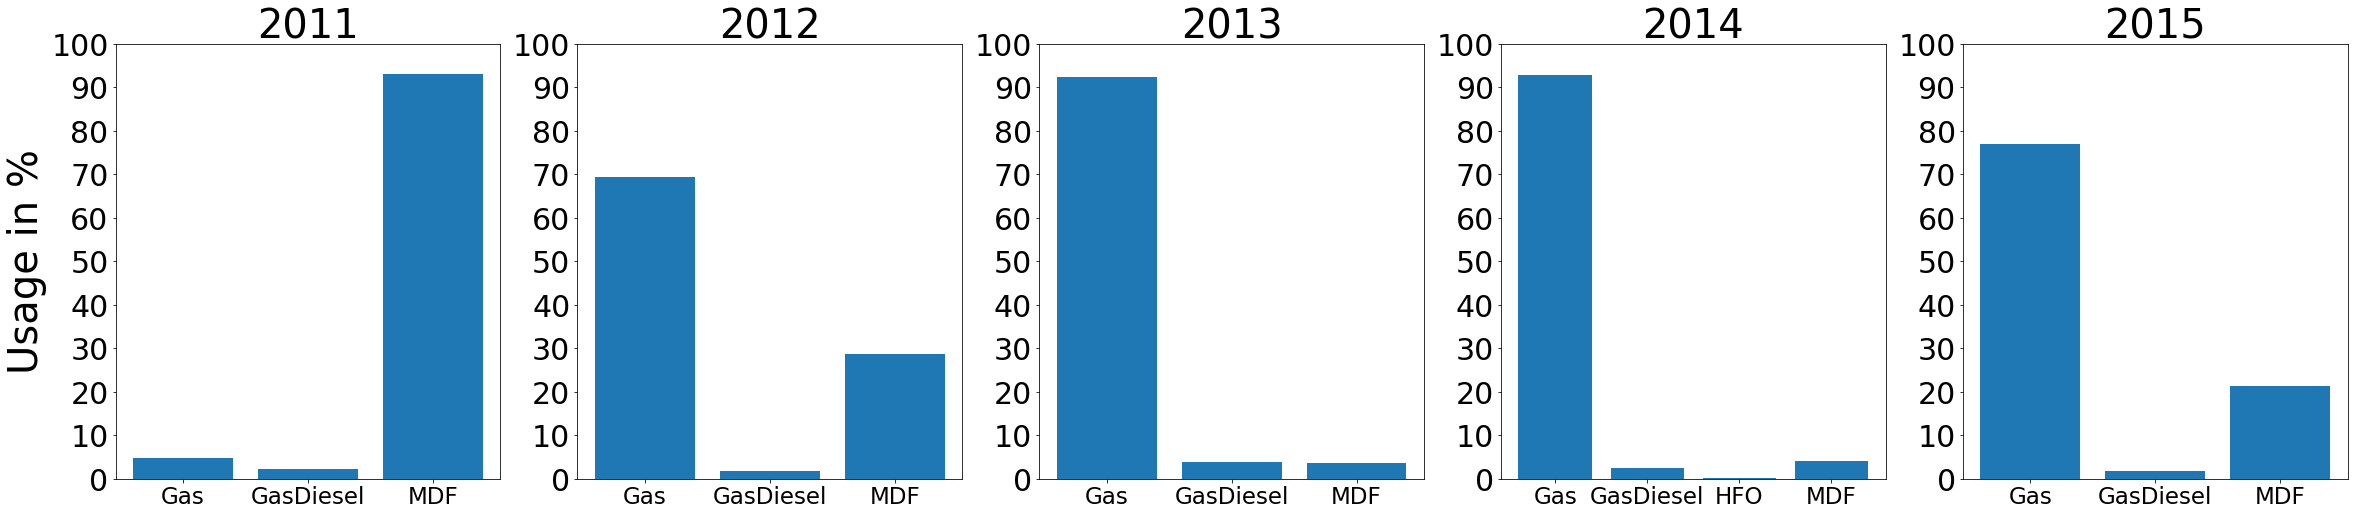

MDF = Diesel


In [33]:
plt.figure(figsize=(40, 8))

for i,year in enumerate([2011,2012,2013,2014,2015]):
    plt.subplot(1,5,i+1)
    if year == 2011:
        plt.ylabel("Usage in %",fontsize=40)
    plt.bar(fuel_year[year].index, fuel_year[year]*100, align='center') # plot
    plt.yticks(np.arange(0, 101, 10),fontsize=30)
    plt.xticks(fontsize=23)
    plt.title(year,fontsize=40)
plt.show()
print("MDF = Diesel")

This Analysis was created by Sebastian Nichtern (https://www.linkedin.com/in/sebastiannichtern/)